In [23]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec
import os

Parámetros del sistema

In [2]:
m = 1

a = open('./param.txt','r')

param = a.readlines()
Ws = []
dt = float(param[0].split()[2])
tf = int(param[1].split()[2])
w_0 = float(param[2].split()[2])
W_0 = float(param[3].split()[2])
f_0 = float(param[4].split()[2])
N = int(param[5].split()[2])
X_0 = float(param[6].split()[2])
for i in range(7,len(param)):
    Ws += param[i].split()
Ws = Ws[2:]
a.close()

for i in range(np.size(Ws)):
    Ws[i] = float(Ws[i])

Parámetro variable

In [3]:
w = Ws[3]
print(w)

0.642


Frecuencia natural del oscilador

In [4]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [5]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [6]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [7]:
x = np.linspace(-25,25,2500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


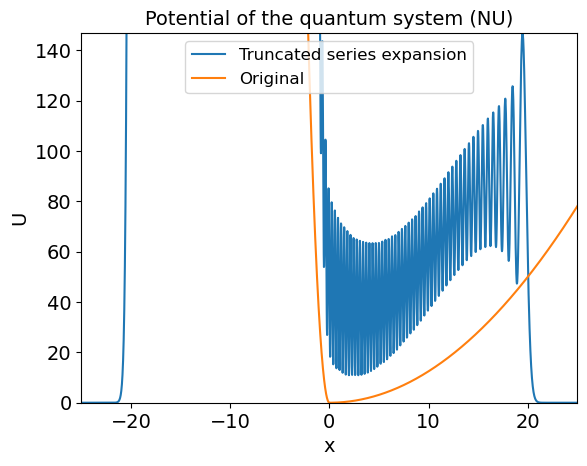

In [8]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system (NU)',fontsize = 14)
plt.xlabel('x',fontsize = 14)
plt.ylabel('U',fontsize = 14)
plt.legend(fontsize = 12)
plt.show()

Simulación de la dinámica cuántica

In [9]:
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [10]:
def check_state(psi):
    check = np.sum(psi[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [11]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

In [12]:
def H1coeff(t,args):
    return f_0*m*np.cos(args['w']*t)

In [13]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
options = Options(store_states=True,nsteps=5000)

args = {'w': w}
H = [H0,[H1,H1coeff]]
result.append(mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options,args=args))

Wigner function evolution

In [14]:
Wigner = []
wig_xvec = np.linspace(-5,20,120)
wig_pvec = np.linspace(-30,30,120)
indW = np.array([np.searchsorted(tvec,i) for i in range(int(tf/1))]) # Calculamos los índices
tW = tvec[indW]

for i in tqdm(tW):   
    Wigner.append(wigner(result[0].states[int(i/dt)], wig_xvec, wig_pvec))

100%|██████████| 800/800 [10:22<00:00,  1.28it/s]


In [33]:
np.shape(Wigner[0])

(120, 120)

In [34]:
neg = []
#pos = []

for j in range(np.shape(Wigner)[0]):
    neg.append(100*np.sum(((Wigner[j]<0)*1)*np.abs(Wigner[j]))/np.sum(np.abs(Wigner[j])))
    #pos.append(100*np.sum(((Wigner[i]>=0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))

Probability density

In [43]:
prob = []

for i in tqdm(tW):
    psi_x = 0
    for j in range(N):
        psi_x = psi_x + autoest(j,x,False)*result[0].states[int(i/dt)][j]
    prob.append(np.abs(psi_x)**2)

100%|██████████| 800/800 [01:11<00:00, 11.18it/s]


Save animations and figures

In [44]:
newpath = r'.\Wneg' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [45]:
np.savetxt('.\Wneg/neg ω = '+str(format(w,'.3f'))+'.txt',neg)

In [46]:
l = open('.\Wneg/neg ω = '+str(format(w,'.3f'))+'.txt','r')
Neg = l.readlines()

for j in range(len(Neg)):
    Neg[j] = float((Neg[j].split())[0])
    neg = (Neg)

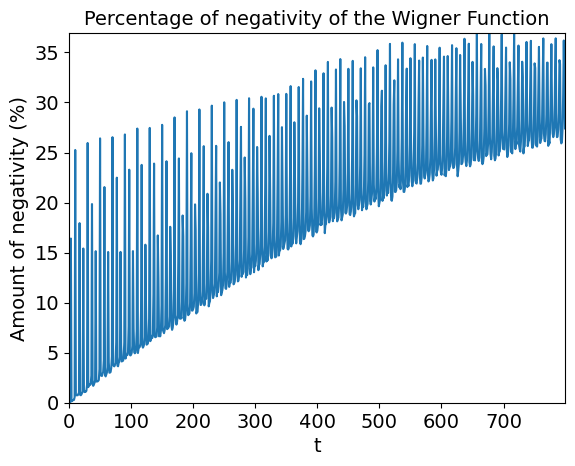

In [47]:
plt.plot(tW,neg)
plt.xlim([0,max(tW)])
plt.ylim([0,np.max(neg)])
plt.title('Percentage of negativity of the Wigner Function',fontsize = 14)
plt.xlabel('t',fontsize = 14)
plt.ylabel('Amount of negativity (%)',fontsize = 14)
plt.savefig('.\Results (ω = '+str(format(w,'.3f'))+')/Negativity (ω = '+str(format(w,'.3f'))+').png',dpi=250)

In [48]:
def update_Wigner(num,Wigner):
    plt.cla()
    plt.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec+math.sqrt(w_0*m), Wigner[num], 100, cmap=cm.RdBu, norm=nrm)
    plt.xlim([np.min(wig_xvec/math.sqrt(w_0*m)),np.max(wig_xvec/math.sqrt(w_0*m))])
    plt.ylim([np.min(wig_pvec*math.sqrt(w_0*m)),np.max(wig_pvec*math.sqrt(w_0*m))])
    plt.title('Evolution of the Wigner function (t = '+str(format(tW[num],'.3f'))+')',fontsize = 14)
    plt.xlabel('x',fontsize = 14)
    plt.ylabel('p',fontsize = 14)

c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


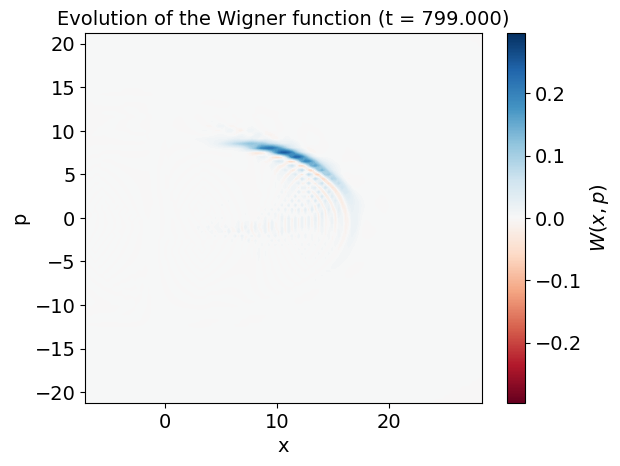

In [50]:
imW = plt.figure()
wmap = wigner_cmap(Wigner[0])
nrm = mpl.colors.Normalize(-Wigner[0].max(), Wigner[0].max())
figW = plt.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), Wigner[0], 100, cmap=cm.RdBu, norm=nrm)
cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu))
cbar.set_label(label='$W(x,p)$',fontsize = 14)
animW = animation.FuncAnimation(imW, update_Wigner, range(np.size(tW)), fargs = (Wigner, ), interval = 100)
animW.save('.\Results (ω = '+str(format(w,'.3f'))+')WIGNER (ω = '+str(format(w,'.3f'))+' s⁻¹).gif')
animW.save('.\Results (ω = '+str(format(w,'.3f'))+')WIGNER (ω = '+str(format(w,'.3f'))+' s⁻¹).mp4')

In [51]:
def update_prob(num,prob):
    ax1.cla()
    ax2.cla()
    ax1.plot(x, prob[num][0], label = '$|Ψ(x)|^2$', color = 'purple')
    ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
    ax1.set_xlim([np.min(x),np.max(x)])
    ax1.set_ylim([0,1.5])
    ax2.set_ylim([0,100])
    ax1.set_title('Evolution of probability density (t = '+str(format(tW[num],'.3f'))+')',fontsize = 14)
    ax1.set_xlabel('x',fontsize = 14)
    ax1.set_ylabel('$|Ψ(x)|^2$',fontsize = 14)
    ax2.set_ylabel('U(x)',fontsize = 14)
    ax2.legend(fontsize = 12)

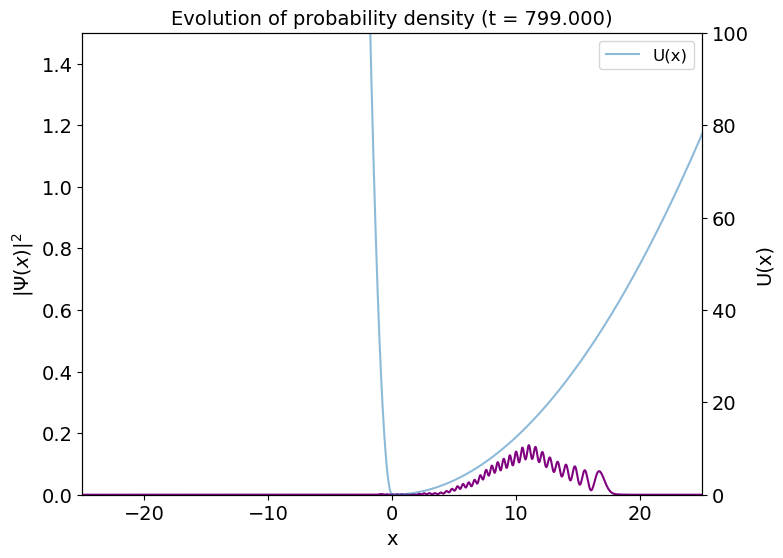

In [52]:
imP = plt.figure(figsize = (8,6))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(x, prob[0][0], label = '$|Ψ(x)|^2$', color = 'purple')
ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
animP = animation.FuncAnimation(imP, update_prob, range(np.size(tW)), fargs = (prob, ), interval = 100)
animP.save('.\Results (ω = '+str(format(w,'.3f'))+')prob (ω = '+str(format(w,'.3f'))+' s⁻¹).gif')
animP.save('.\Results (ω = '+str(format(w,'.3f'))+')prob (ω = '+str(format(w,'.3f'))+' s⁻¹).mp4')